### Incluindo bibliotecas necessárias:

In [77]:
# Importando bibliotecas básicas:
import numpy as np
import pandas as pd

# Instalando e importando a toolbox Plotly:
!pip install plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Instalando e importando a toolbox GA:
!pip install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga

# Instalando e importando a toolbox Control:
!pip install control
from control.matlab import *

### Função para o erro:

In [3]:
def errorF(p):
    # Variáveis de otimização:
    kp = p[0]
    ki = p[1]
    
    # Declaração de parâmetros:
    N = 111.5
    J = 5.9e6/N**2 + 59
    D = 0
    
    # Declaração das funções basicas:
    G = tf([1], [J,D]) # Planta
    C = tf([kp, ki], [1,0]) # Controlador
    MA = G*C # Malha aberta
    
    # Funções da Gang of four:
    ftMF = tf([ki], [J, (D+kp), ki])
    ftAC = tf([ki], [1,0])/(1+MA)
    ftRD = G/(1+MA)
    ftSE = 1/(1+MA)
    
    # Levantando a performance através da resposta ao degrau:
    iMF = stepinfo(ftMF,SettlingTimeThreshold=0.02)
    iAC = stepinfo(ftAC,SettlingTimeThreshold=0.02)
    iRD = stepinfo(ftRD,SettlingTimeThreshold=0.02)
    iSE = stepinfo(ftSE,SettlingTimeThreshold=0.02)
    
    # Mininização da ultrapassagem percentual e tempo de acomodação:
    minMF = abs(iMF['SettlingTime']+iMF['Peak'])**2 # Malha fechada
    minRD = abs(iRD['SettlingTime']+iRD['Peak']) # Rejeição disturbio
    
    # Mininização da ultrapassagem percentual:
    minAC = abs(iAC['Peak']) # Ação de controle
    minSE = abs(2-iSE['Peak'])**2 # Sensibilidade
    
    # Objetivos de minimização:
    eq = minMF + minRD + minAC + minSE
    
    return eq

### Otimização:

 The best solution found:                                                                           
 [1342.88836998 1767.47753364]

 Objective function:
 nan


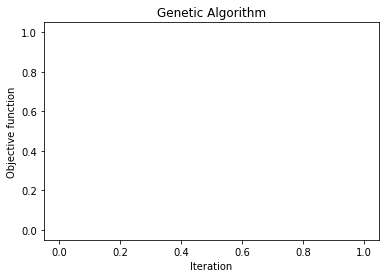

Retorno do GA:
kp =  1342.8883699801227
ki =  1767.4775336372213


In [15]:
varbound=np.array([[1e-6, 2e3], [1e-6,2e3]])

algorithm_param = {'max_num_iteration': 100,\
                   'population_size':35,\
                   'mutation_probability':0.5,\
                   'elit_ratio': 0.0001,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.2,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

model=ga(function=errorF,\
            dimension=2,\
            variable_type='real',\
            variable_boundaries=varbound,\
            algorithm_parameters=algorithm_param)

model.run()

# Resposta ótima:
p = model.best_variable

print('Retorno do GA:')
print('kp = ', p[0])
print('ki = ', p[1])

### Resultados:

Após a otimização será feita a verificação dos ganhos levantados. Serão plotadas as respostas ao degrau para cada uma das funções de transferência:

In [81]:
def analiseDegrau(sys, nameF, si):
    # Levantando a resposta ao degrau:
    y,t = step(sys)

    if si: # Listando características:
        info = stepinfo(sys)
        info = {chave: [valor] for chave, valor in info.items()}
        info = pd.DataFrame(info)
        display(info)

    # Plotando o resultado:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=y, mode='lines', name=nameF))
    fig.update_layout(xaxis_title='tempo (s)', yaxis_title=nameF, height=400, width=600)
    fig.show()
    
def analiseBode(sys):
    [m,a,w] = bode(sys, plot=False)
    print(f'Máxima magnitude (dB): {max(20 * np.log10(m))}')
    
    # Criando os subgráficos
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

    # Plot do primeiro subgráfico - Magnitude em dB
    fig.add_trace(go.Scatter(x=w, y=20 * np.log10(m), mode='lines', name='Magnitude (dB)', line=dict(color='red')), row=1, col=1)
    fig.update_xaxes(title_text='', type='log', row=1, col=1)
    fig.update_yaxes(title_text='Magnitude (dB)', row=1, col=1)

    # Plot do segundo subgráfico - Fase em graus
    fig.add_trace(go.Scatter(x=w, y=180 / np.pi * a, mode='lines', name='Fase (°)', line=dict(color='blue')), row=2, col=1)
    fig.update_xaxes(title_text='frequência (rad/s)', type='log', row=2, col=1)
    fig.update_yaxes(title_text='Fase (°)', row=2, col=1)

    fig.update_layout(height=400, width=600, showlegend=False)
    fig.show()

#### Recalculando funções da Gang of Four com os ganhos otimizados:

In [16]:
# Ganhos otimizados:
kp =  p[0]#829.7140137059075
ki =  p[1]#678.8226845200812

# Declaração de parâmetros:
N = 111.5
J = 5.9e6/N**2 + 59
D = 0

# Declaração das funções basicas:
G = tf([1], [J,D])
C = tf([kp, ki], [1,0])
MA = G*C

# Funções da Gang of four:

ftAC = tf([ki], [1,0])/(1+MA)
ftRD = G/(1+MA)
ftSE = 1/(1+MA)

#### Análise da malha fechada:

In [86]:
# Análise malha fechada:
ftMF = tf([ki], [J, (D+kp), ki])
analiseDegrau(ftMF, "Malha Fechada", True)
analiseBode(ftMF)

,RiseTime,SettlingTime,SettlingMin,SettlingMax,Overshoot,Undershoot,Peak,PeakTime,SteadyStateValue
0,1.164406,3.326873,0.9042,1.049459,4.945895,0,1.049459,2.384259,1.0


Máxima magnitude (dB): 0.008378224600100716


In [68]:
# Análise rejeição do distúrbio:
ftRD = G/(1+MA)
analiseDegrau(ftRD, "Rejeição Distúrbio", False)

In [69]:
# Análise ação de controle:
ftAC = tf([ki], [1,0])/(1+MA)
analiseDegrau(ftAC, "Ação Controle", False)

In [82]:
# Análise função de sensibilidade:
ftSE = 1/(1+MA)

analiseBode(ftSE)

Máxima magnitude (dB): 0.008378175262135936
